In [ ]:
# Importing Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Importing Dataset
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Train_data.csv"
df = pd.read_csv(path)
#df = pd.read_csv("Train_data.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Warehouse id,Region,SKU id,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,...,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24


In [ ]:
df.columns = df.columns.str.replace('[-]', '', regex=True)
df.head()

,Warehouse id,Region,SKU id,Apr18,May18,Jun18,Jul18,Aug18,Sep18,Oct18,...,Aug20,Sep20,Oct20,Nov20,Dec20,Jan21,Feb21,Mar21,Apr21,May21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24


After feature engineering we narrow down to below observations.  
The significant factors seem to be:   
1. Region  
2. April 2021 (most important)  
3. September 2020  
4. October 2020  
5. October 2019  

In [ ]:
# Univariate LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# define model
def fit_LSTM_model(X_train, y_train, epochs, neurons):
  model = Sequential()
  model.add(LSTM(neurons, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=epochs, verbose=0)
  return model

In [ ]:
from sklearn.metrics import *
mape = []
pred = []
def get_LSTM_accuracy(model, X, Y, n_steps, n_features):
  y_pred = []
  for i in range(len(X)):
    x = X[i].reshape((1, n_steps, n_features))
    y = model.predict(x, verbose=0)
    y_pred.append(y.copy()[0][0])

  print("Predicted: ", y_pred)
  print("Actual: ", Y)

  print("Mean absolute error =", round(mean_absolute_error(Y, y_pred), 2)) 
  print("Mean squared error =", round(mean_squared_error(Y, y_pred), 2)) 
  print("Median absolute error =", round(median_absolute_error(Y, y_pred), 2))
  print("Mean absolute percentage error =", round(mean_absolute_percentage_error(Y, y_pred), 2))
  mape.append(round(mean_absolute_percentage_error(Y, y_pred), 2))
  pred.append(y_pred)
  print("Explain variance score =", round(explained_variance_score(Y, y_pred), 2)) 
  print("R2 score =", round(r2_score(Y, y_pred), 2))

  data_plot = pd.DataFrame({"Time": range(Y.shape[0]), "Predict": y_pred, "Actual": Y})
  sns.lineplot(x = "Time", y = "Actual", data=data_plot, legend='brief', label="Actual")
  sns.lineplot(x = "Time", y = "Predict", data=data_plot, legend='brief', label="Predicted")
  plt.show()
  print(pred)
  print(mape)

In [ ]:
def train_LSTM_model(time_series, epochs, neurons, n_steps, n_features, percentage_train):
  X, y = split_sequence(time_series, n_steps)

  print("X: ", X.shape)
  print("Y: ", y.shape)

  X_train, y_train, X_test, y_test = X[0:36], y[0:36], X[36:], y[36:]
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

  print("X_train: ", X_train.shape)
  print("y_train: ", y_train.shape)
  print("X_test: ", X_test.shape)
  print("y_test: ", y_test.shape)

  LSTM_model = fit_LSTM_model(X_train, y_train, epochs, neurons)

  return X_train, y_train, X_test, y_test, LSTM_model

In [ ]:
time_df = df.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series = time_df.sum()
time_series = time_pd_series.to_numpy()

df_N = df.where(df["Region"] == "NORTH")
time_df_N = df_N.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series_N = time_df_N.sum()
time_series_N = time_pd_series_N.to_numpy()

df_E = df.where(df["Region"] == "EAST")
time_df_E = df_E.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series_E = time_df_E.sum()
time_series_E = time_pd_series_E.to_numpy()

df_W = df.where(df["Region"] == "WEST")
time_df_W = df_W.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series_W = time_df_W.sum()
time_series_W = time_pd_series_W.to_numpy()

df_S = df.where(df["Region"] == "SOUTH")
time_df_S = df_S.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series_S = time_df_S.sum()
time_series_S = time_pd_series_S.to_numpy()

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 36/37
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)


Predicted:  [212996.72, 186144.52, 179559.12, 135398.16, 150138.03, 136093.88, 138837.11, 173232.38, 182030.5, 152131.83, 124650.82, 330139.1, 243801.81, 225351.97, 217040.5, 148509.45, 161552.17, 152159.92, 138837.11, 196158.95, 231689.5, 209432.19, 228944.61, 168396.19, 12419.864, 154016.56, 173455.45, 147266.73, 183150.11, 178381.67, 204990.97, 221700.67, 333490.44, 235742.36, 236191.02, 332846.78]
Actual:  [225281 217311 163865 181704 164707 168027 209654 220302 184117 150858
 399551 295061 272732 262673 179733 195518 184151 168027 237401 280402
 253465 277080 203801  15030 186398 209924 178229 221657 215886 248090
 268313 403607 285307 285850 402828 156740]
Mean absolute error = 64464.11
Mean squared error = 7971846727.3
Median absolute error = 46657.2
Mean absolute percentage error = 0.53
Explain variance score = -0.19
R2 score = -0.44


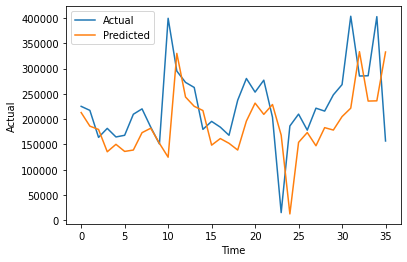

[0.53]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [129510.96]
Actual:  [126886]
Mean absolute error = 2624.96
Mean squared error = 6890419.92
Median absolute error = 2624.96
Mean absolute percentage error = 0.02
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


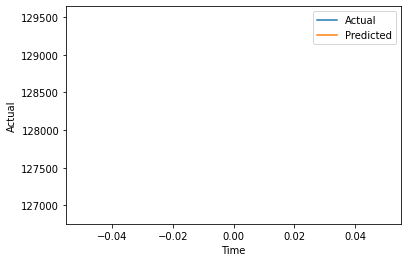

[0.53, 0.02]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 36/37
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series_N, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)


Predicted:  [53857.16, 44044.152, 42103.363, 34634.36, 38245.715, 34203.695, 28415.82, 58149.695, 61145.316, 51843.188, 28057.639, 119257.75, 66330.13, 50250.027, 59064.496, 41306.78, 49334.523, 46688.633, 30574.75, 59578.188, 91390.07, 80077.49, 72388.94, 50821.426, 4730.8955, 15804.22, 33877.887, 51012.13, 48454.902, 43541.01, 45078.582, 58096.914, 109822.62, 69407.38, 63848.203, 97340.51]
Actual:  [ 62588.  59830.  49216.  54348.  48604.  40379.  82633.  86890.  73671.
  39870. 169472.  94258.  71407.  83933.  58698.  70106.  66346.  43447.
  84663. 129870. 113794. 102868.  72219.   6721.  22457.  48141.  72490.
  68856.  61873.  64058.  82558. 156064.  98631.  90731. 138326.  22672.]
Mean absolute error = 30592.57
Mean squared error = 1810999520.41
Median absolute error = 20920.3
Mean absolute percentage error = 0.59
Explain variance score = -0.13
R2 score = -0.49


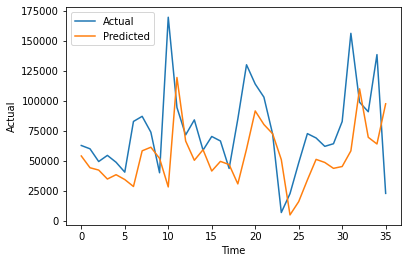

[0.53, 0.02, 0.59]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [15955.514]
Actual:  [22351.]
Mean absolute error = 6395.49
Mean squared error = 40902245.37
Median absolute error = 6395.49
Mean absolute percentage error = 0.29
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


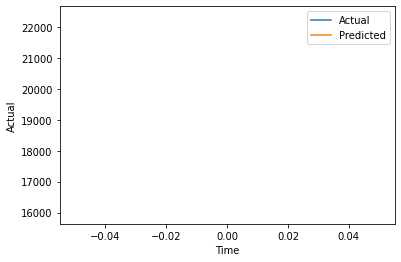

[0.53, 0.02, 0.59, 0.29]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 36/37
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series_E, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)


Predicted:  [38288.543, 37002.0, 39307.97, 23066.098, 21331.484, 18666.926, 12190.462, 18674.217, 19832.836, 17835.082, 18226.81, 45771.18, 46036.973, 50358.59, 39775.26, 24967.744, 24768.232, 18642.402, 13911.818, 23321.95, 27006.596, 27338.672, 32714.844, 32261.473, 1457.9956, 61997.137, 47295.68, 15325.625, 32990.582, 26090.568, 25962.645, 25716.074, 51462.855, 35808.914, 45179.277, 59576.504]
Actual:  [55823. 59302. 34798. 32181. 28161. 18390. 28172. 29920. 26906. 27497.
 69053. 69454. 75974. 60007. 37667. 37366. 28124. 20987. 35184. 40743.
 41244. 49355. 48671.  2198. 93533. 71353. 23120. 49771. 39361. 39168.
 38796. 77640. 54023. 68160. 89881. 58276.]
Mean absolute error = 19026.85
Mean squared error = 690337583.74
Median absolute error = 13657.42
Mean absolute percentage error = 0.73
Explain variance score = -0.04
R2 score = -0.6


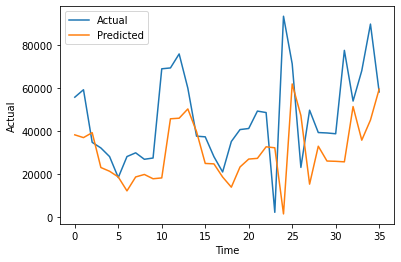

[0.53, 0.02, 0.59, 0.29, 0.73]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [38627.914]
Actual:  [34924.]
Mean absolute error = 3703.91
Mean squared error = 13718979.38
Median absolute error = 3703.91
Mean absolute percentage error = 0.11
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


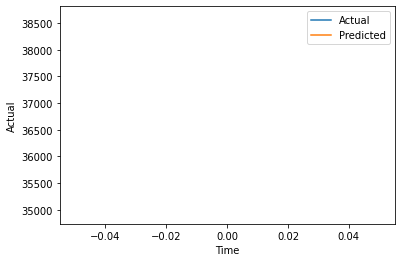

[0.53, 0.02, 0.59, 0.29, 0.73, 0.11]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 36/37
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series_W, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)


Predicted:  [34173.234, 34023.043, 35502.95, 29854.604, 36875.133, 35084.613, 46082.496, 36476.453, 39579.387, 28690.021, 28281.904, 60547.387, 39889.996, 40791.938, 40583.555, 30008.73, 35045.297, 35847.37, 39638.36, 47919.406, 44454.754, 35113.707, 50898.098, 28627.111, 2547.837, 15572.142, 21036.482, 25996.773, 33773.77, 41605.023, 57227.42, 55011.492, 70065.36, 53173.793, 45768.742, 62818.367]
Actual:  [43266. 45148. 37965. 46893. 44616. 58602. 46386. 50332. 36484. 35965.
 76997. 50727. 51874. 51609. 38161. 44566. 45586. 50407. 60938. 56532.
 44653. 64726. 36404.  3239. 19802. 26751. 33059. 42949. 52908. 72775.
 69957. 89101. 67620. 58203. 79885. 27114.]
Mean absolute error = 15287.6
Mean squared error = 357980422.57
Median absolute error = 12376.05
Mean absolute percentage error = 0.52
Explain variance score = 0.12
R2 score = -0.24


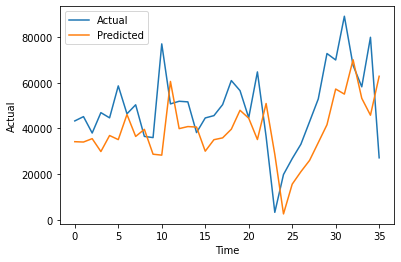

[0.53, 0.02, 0.59, 0.29, 0.73, 0.11, 0.52]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [21321.928]
Actual:  [52564.]
Mean absolute error = 31242.07
Mean squared error = 976067079.45
Median absolute error = 31242.07
Mean absolute percentage error = 0.59
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


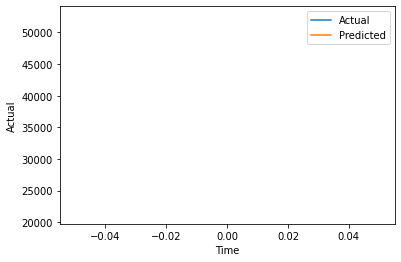

[0.53, 0.02, 0.59, 0.29, 0.73, 0.11, 0.52, 0.59]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 36/37
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series_S, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)


Predicted:  [64704.82, 51427.613, 42878.81, 33867.508, 39039.0, 35031.82, 40958.496, 42419.55, 42983.11, 38047.715, 38427.734, 67942.26, 65187.523, 59410.43, 54273.71, 36552.707, 35156.34, 35653.598, 43004.133, 45777.46, 43061.54, 43479.56, 48619.516, 37603.82, 2322.7195, 40918.074, 51488.25, 40072.33, 48579.086, 49923.71, 58288.164, 62260.57, 65333.066, 52583.03, 55593.27, 76599.414]
Actual:  [63604. 53031. 41886. 48282. 43326. 50656. 52463. 53160. 47056. 47526.
 84029. 80622. 73477. 67124. 45207. 43480. 44095. 53186. 56616. 53257.
 53774. 60131. 46507.  2872. 50606. 63679. 49560. 60081. 61744. 72089.
 77002. 80802. 65033. 68756. 94736. 48678.]
Mean absolute error = 14582.54
Mean squared error = 354015458.96
Median absolute error = 12092.12
Mean absolute percentage error = 0.56
Explain variance score = 0.02
R2 score = -0.4


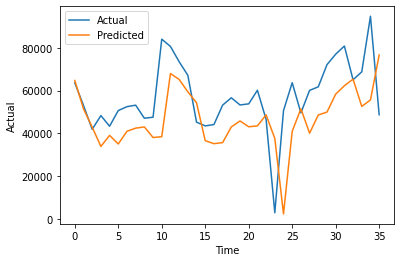

[0.53, 0.02, 0.59, 0.29, 0.73, 0.11, 0.52, 0.59, 0.56]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [39359.184]
Actual:  [17047.]
Mean absolute error = 22312.18
Mean squared error = 497833536.72
Median absolute error = 22312.18
Mean absolute percentage error = 1.31
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


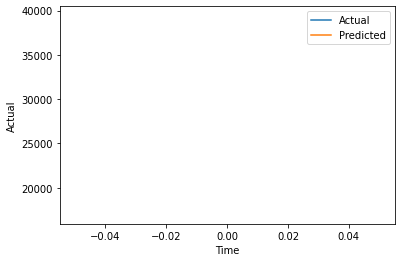

[0.53, 0.02, 0.59, 0.29, 0.73, 0.11, 0.52, 0.59, 0.56, 1.31]


In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
time_df.head()

,Apr18,May18,Jun18,Jul18,Aug18,Sep18,Oct18,Nov18,Dec18,Jan19,...,Aug20,Sep20,Oct20,Nov20,Dec20,Jan21,Feb21,Mar21,Apr21,May21
0,27,13,30,14,22,8,8,8,8,8,...,12,8,8,8,8,8,14,16,8,12
1,88,28,127,130,58,10,7,7,7,13,...,16,7,7,7,7,7,13,43,13,43
2,6,6,6,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,162,184,110,172,90,40,18,26,18,66,...,82,78,38,18,22,28,36,352,58,18
4,171,402,627,615,300,417,141,42,72,33,...,468,216,75,6,30,66,141,699,183,24


In [ ]:
time_series = time_df.to_numpy()
time_series

array([[ 27,  13,  30, ...,  16,   8,  12],
       [ 88,  28, 127, ...,  43,  13,  43],
       [  6,   6,   6, ...,   8,  26,   6],
       ...,
       [ 21,  13,  13, ...,  13,  13,  13],
       [ 15,  13,  13, ...,  17,   9,   9],
       [252, 105,  33, ..., 783, 375,  33]])

In [ ]:
np.shape(time_series)

(1039, 38)

X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)
Predicted:  [7.949433]
Actual:  [12]
Mean absolute error = 4.05
Mean squared error = 16.41
Median absolute error = 4.05
Mean absolute percentage error = 0.34
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


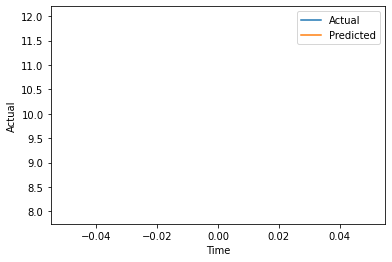

[[7.949433]]
[0.34]
X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)
Predicted:  [7.2365785]
Actual:  [43]
Mean absolute error = 35.76
Mean squared error = 1279.02
Median absolute error = 35.76
Mean absolute percentage error = 0.83
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


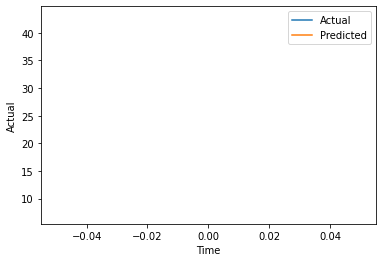

[[7.949433], [7.2365785]]
[0.34, 0.83]
X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)
Predicted:  [9.296175]
Actual:  [6]
Mean absolute error = 3.3
Mean squared error = 10.86
Median absolute error = 3.3
Mean absolute percentage error = 0.55
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


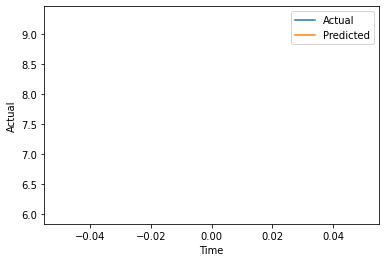

[[7.949433], [7.2365785], [9.296175]]
[0.34, 0.83, 0.55]
X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)
Predicted:  [30.00163]
Actual:  [18]
Mean absolute error = 12.0
Mean squared error = 144.04
Median absolute error = 12.0
Mean absolute percentage error = 0.67
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


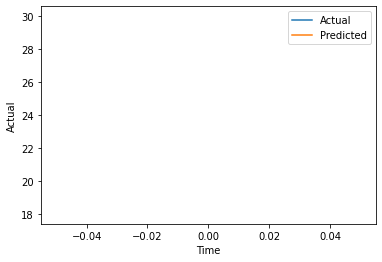

[[7.949433], [7.2365785], [9.296175], [30.00163]]
[0.34, 0.83, 0.55, 0.67]
X:  (37, 1)
Y:  (37,)
X_train:  (36, 1, 1)
y_train:  (36,)
X_test:  (1, 1, 1)
y_test:  (1,)
Predicted:  [48.133945]
Actual:  [24]
Mean absolute error = 24.13
Mean squared error = 582.45
Median absolute error = 24.13
Mean absolute percentage error = 1.01
Explain variance score = 1.0
R2 score = nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


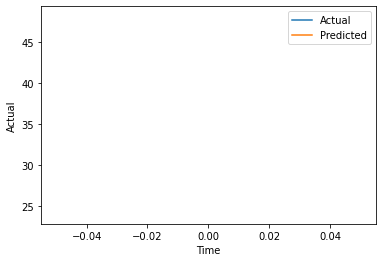

[[7.949433], [7.2365785], [9.296175], [30.00163], [48.133945]]
[0.34, 0.83, 0.55, 0.67, 1.01]


In [ ]:
for i in range(0,5):
  X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series[i,:], epochs, neurons, n_steps, n_features, percentage_train)
  get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)

In [ ]:
avg_mape = np.average(mape)
avg_mape

0.47266666666666673

[0.2, 0.41, 0.11, 0.46, 0.62, 0.2, 0.41, 0.12, 0.47, 0.61, 0.23, 0.97, 0.97, 0.65, 0.61, 0.14, 0.7, 1.0, 0.77, 0.13, 0.58, 1.52, 0.73, 0.12, 0.13, 0.15, 0.22, 0.21, 0.17, 0.48, 0.18, 0.19, 0.15, 0.12, 0.75, 0.73, 0.62, 0.12, 0.78, 0.03, 0.35, 0.92, 0.76, 0.95, 0.71, 0.24, 0.26, 0.29, 0.22, 0.57, 0.58, 0.96, 0.59, 0.63, 0.6, 0.95, 0.58, 0.85, 0.21, 0.29, 0.16, 0.25, 0.27, 0.35, 0.03, 0.55, 0.33, 0.18, 0.29, 0.5, 0.31, 0.27, 0.34, 0.67, 0.56, 0.77, 0.58, 0.34, 0.17, 0.28, 0.07, 0.69, 0.71, 0.89, 0.84, 0.71, 0.63, 0.15, 0.29, 0.31, 0.49, 0.07, 0.69, 0.91, 0.59, 0.56, 0.82, 0.56, 0.39, 0.21, 0.41, 0.75, 0.44, 0.29, 0.62, 0.11, 0.13, 0.72, 0.81, 0.37, 0.96, 0.84, 0.78, 0.64, 0.45, 0.82, 0.29, 0.82, 0.43, 0.42, 0.11, 0.24, 0.06, 0.24, 0.81, 0.84, 0.56, 0.82, 0.89, 0.7, 0.21, 0.86, 0.53, 0.25, 0.64, 0.77, 0.93, 0.96, 0.9, 0.85, 0.85, 0.51, 0.82, 0.72, 0.96, 0.93, 0.37, 0.49, 0.5, 0.53, 0.68, 0.74, 0.88, 0.62, 0.88, 0.84, 0.86, 0.45, 0.45, 0.34, 0.07, 0.73, 0.53, 0.75, 0.75, 0.47, 0.04, 0.04, 0.04, 0.67, 0.53, 0.56, 0.44, 0.1, 0.11, 0.08, 0.0, 0.68, 0.07, 0.08, 0.0, 0.12, 0.05, 0.1, 0.1, 0.05, 0.65, 0.12, 0.08, 0.58, 0.55, 0.04, 0.28, 0.31, 0.58, 0.18, 0.16, 0.29, 0.56, 0.14, 0.71, 0.29, 0.36, 0.68, 0.11, 0.07, 0.08, 0.23, 0.09, 0.43, 0.84, 0.41, 0.03, 0.26, 0.37, 0.68, 0.46, 0.05, 0.3, 0.31, 0.31, 0.2, 0.1, 0.29, 0.65, 0.71, 0.56, 0.37, 0.97, 0.97, 0.79, 0.1, 0.14, 0.33, 0.6, 0.2, 0.54, 0.31, 0.37, 0.2, 0.14, 0.65, 0.72, 0.16, 0.65, 0.22, 0.72, 0.58, 0.93, 0.23, 0.76, 0.81, 0.17, 0.19, 0.23, 0.13, 0.15, 0.21, 0.27, 0.17, 0.19, 0.14, 0.16, 0.42, 0.65, 0.62, 0.11, 0.76, 0.45, 0.26, 0.48, 0.23, 0.77, 0.55, 0.72, 0.25, 0.17, 0.17, 0.41, 0.38, 0.69, 0.54, 0.22, 0.25, 0.09, 0.17, 0.25, 0.16, 0.28, 0.95, 0.7, 0.59, 0.62, 0.25, 0.73, 0.04, 0.46, 0.87, 0.42, 0.92, 0.52, 0.57, 0.52, 0.7, 0.15, 0.36, 0.67, 0.05, 0.39, 0.59, 0.73, 0.43, 0.58, 0.54, 0.6, 0.79, 0.83, 0.47, 0.87, 0.23, 0.2, 0.11, 0.21, 0.86, 0.97, 0.45, 0.75, 1.27, 0.5, 0.65, 0.48, 0.34, 0.67, 0.66, 0.31, 0.56, 0.64, 0.16, 0.82, 0.48, 0.01, 0.59, 0.14, 0.81, 0.13, 0.61, 0.06, 0.11, 0.1, 0.41, 0.91, 0.85, 0.79, 0.9, 0.49, 0.86, 0.61, 0.69, 0.46, 0.78, 0.07, 0.21, 0.45, 0.22, 0.96, 0.45, 0.72, 0.65, 0.49, 0.84, 0.78, 0.38, 0.95, 0.98, 0.69, 0.08, 0.11, 0.87, 0.84, 0.95, 0.95, 0.93, 0.9, 0.81, 0.8, 0.86, 0.85, 0.62, 0.76, 0.91, 0.97, 0.55, 0.68, 0.74, 0.56, 0.69, 0.04, 0.43, 0.19, 0.56, 0.02, 0.02, 0.01, 0.14, 0.5, 0.33, 0.55, 0.0, 0.07, 0.01, 0.71, 0.56, 0.41, 0.01, 0.0, 0.16, 0.39, 0.23, 0.16, 0.59, 0.26, 0.68, 0.09, 0.0, 0.02, 0.02, 0.23, 0.18, 0.24, 0.12, 0.3, 0.71, 0.09, 0.26, 0.44, 0.47, 0.87, 0.48, 0.56, 0.55, 0.94, 0.86, 0.78, 0.72, 0.39, 0.7, 0.39, 0.27, 0.43, 0.55, 0.57, 0.67, 0.14, 0.33, 0.72, 0.24, 0.28, 0.71, 0.46, 0.72, 0.57, 0.49, 0.91, 0.85, 0.08, 0.13, 0.17, 0.19, 0.14, 0.11, 0.15, 0.18, 0.14, 0.12, 0.1, 0.31, 0.16, 0.2, 0.13, 0.12, 0.68, 0.34, 0.39, 0.09, 0.41, 0.39, 0.18, 0.31, 0.48, 0.07, 0.28, 0.25, 0.49, 0.82, 0.9, 0.7, 0.27, 0.71, 0.63, 0.25, 0.33, 0.28, 0.15, 0.56, 0.47, 0.72, 0.55, 0.49, 0.87, 0.54, 0.18, 0.15, 0.19, 0.22, 0.21, 0.29, 0.71, 0.13, 0.38, 0.32, 0.15, 0.18, 0.27, 0.15, 0.2, 0.7, 0.48, 0.41, 0.35, 0.21, 0.41, 0.62, 0.1, 0.77, 0.69, 0.61, 0.41, 0.47, 0.45, 0.0, 0.41, 0.51, 0.06, 0.68, 0.47, 0.03, 0.7, 0.55, 0.25, 0.52, 0.42, 0.64, 0.26, 0.51, 0.22, 0.27, 0.34, 0.59, 0.64, 0.59, 0.32, 0.17, 0.16, 1.02, 0.64, 0.58, 0.92, 0.83, 0.57, 0.64, 0.91, 0.43, 0.6, 0.22, 0.0, 0.86, 0.57, 0.54, 0.63, 0.08, 0.15, 0.11, 0.12, 0.23, 0.95, 1.0, 0.4, 0.2, 0.62, 0.97, 0.49, 0.61, 0.59, 0.94, 0.39, 0.17, 0.35, 0.43, 0.64, 0.53, 0.2, 0.21, 0.16, 0.35, 0.21, 0.23, 0.16, 0.18, 0.21, 0.13, 0.19, 0.49, 0.55, 0.82, 0.66, 0.28, 0.46, 0.39, 0.62, 0.66, 0.73, 0.79, 0.42, 0.27, 0.21, 0.21, 0.71, 0.83, 0.57, 0.24, 0.5, 0.34, 0.69, 0.6, 0.33, 0.42, 0.59, 0.77, 0.15, 0.29, 0.67, 0.87, 0.89, 0.86, 0.68, 0.74, 0.49, 0.86, 0.76, 0.73, 0.46, 0.54, 0.12, 0.03, 0.49, 0.03, 0.4, 0.32, 0.66, 0.67, 0.03, 0.03, 0.03, 0.52, 0.44, 0.78, 0.51, 0.7, 0.15, 0.0, 0.12, 0.15, 0.0, 0.25, 0.86, 0.13, 0.09, 0.13, 0.12, 0.07, 0.12, 0.16, 0.3, 0.86, 0.21, 0.38, 0.56, 0.19, 0.34, 0.57, 0.0, 0.18, 0.28, 0.18, 0.22, 0.63, 0.18, 0.29, 0.52, 0.17, 0.44, 0.35, 0.44, 0.68, 0.12, 0.08, 0.13, 0.78, 0.0, 0.12, 0.23, 0.0, 0.0, 0.14, 0.12, 0.03, 0.55, 0.12, 0.36, 0.26, 0.37, 0.32, 0.27, 0.42, 0.36, 0.53, 0.2, 0.43, 0.08, 0.15, 0.26, 0.28, 0.54, 0.09, 0.05, 0.14, 0.33, 0.69, 0.79, 0.62, 0.64, 0.22, 0.16, 0.35, 0.19, 0.48, 0.97, 0.48, 0.6, 0.53, 0.3, 0.13, 0.2, 0.07, 0.55, 0.59, 0.39, 0.36, 0.46, 0.52, 0.05, 0.75, 0.52, 0.45, 0.97, 0.96, 0.38, 0.75, 0.63, 0.92, 0.67, 0.19, 0.11, 0.12, 0.1, 0.14, 0.15, 0.15, 0.12, 0.13, 0.51, 0.17, 0.18, 0.15, 0.15, 0.74, 0.4, 0.68, 0.19, 0.9, 0.67, 0.16, 0.39, 0.4, 0.11, 0.18, 0.96, 0.68, 0.96, 0.36, 0.45, 0.18, 0.33, 0.25, 0.43, 0.57, 0.92, 0.88, 0.76, 0.94, 0.35, 0.24, 0.18, 0.16, 0.18, 0.32, 0.11, 0.37, 0.37, 0.36, 0.91, 0.73, 0.51, 0.15, 0.24, 0.26, 0.5, 0.57, 0.41, 0.64, 0.26, 0.17, 0.4, 0.31, 0.02, 0.54, 0.72, 0.49, 0.69, 0.56, 0.34, 0.96, 0.95, 0.85, 0.34, 0.47, 0.51, 0.02, 0.86, 0.96, 0.87, 0.87, 0.46, 0.49, 0.83, 0.5, 0.57, 0.21, 0.92, 0.75, 0.94, 0.9, 0.46, 0.38, 0.56, 0.5, 0.66, 0.78, 0.92, 0.58, 0.26, 0.95, 0.08, 0.14, 0.12, 0.06, 0.66, 0.97, 0.59, 0.92, 0.76, 0.96, 0.97, 0.58, 0.34, 0.47, 0.55, 0.63, 0.57, 0.78, 0.86, 0.32, 0.29, 0.11, 0.35, 0.22, 0.37, 0.21, 0.17, 0.61, 0.12, 0.2, 0.14, 0.94, 0.47, 0.47, 0.97, 0.8, 0.89, 0.76, 0.3, 0.54, 0.16, 0.62, 0.15, 0.22, 0.22, 0.11, 0.39, 0.88, 0.77, 0.68, 0.38, 0.31, 0.11, 0.1, 0.19, 0.62, 0.46, 0.59, 0.45, 1.01, 0.04, 0.5, 0.61, 0.63, 0.66, 0.71, 0.81, 0.78, 0.96, 0.98, 0.97, 0.89, 0.44, 0.08, 0.99, 0.76, 0.47, 0.57, 0.3, 0.34, 0.28, 0.16, 0.72, 0.72, 0.65, 0.58, 0.96, 0.75, 0.96, 0.97, 0.76, 0.55, 0.31, 0.02, 0.36, 0.42, 0.27, 0.46, 0.66, 0.04, 0.02, 0.02, 0.48, 0.51, 0.46, 0.46, 0.07, 0.1, 0.05, 0.0, 0.4, 0.05, 0.11, 0.03, 0.08, 0.07, 0.06, 0.07, 0.4, 0.12, 0.07, 0.31, 0.46, 0.07, 0.39, 0.13, 0.4, 0.37, 0.57, 0.08, 0.1, 0.09, 0.55, 0.07, 0.1, 0.09, 0.03, 0.7, 0.08, 0.27, 0.18, 0.31, 0.28, 0.44, 0.21, 0.52, 0.11, 0.44, 0.0, 0.12, 0.16, 0.69, 0.05, 0.12, 0.54, 0.11, 0.68, 0.49, 0.2, 0.27, 0.62, 0.48, 0.49, 0.83, 0.69, 0.71, 0.16, 0.34, 0.51, 0.23, 0.25, 0.37]

In [ ]:
sub = pd.DataFrame(pred)
sub.to_csv("Prediction.csv")

In [ ]:
sub1 = pd.read_csv("Prediction.csv")
sub1

,Unnamed: 0,0
0,0,7.974054
1,1,7.236871
2,2,8.671747
3,3,30.267874
4,4,48.237946


In [ ]:
X, y = split_sequence(time_series, n_steps)
len(X[37:])

1001

In [ ]:
#X, y = split_sequence(time_series, n_steps)
mape = []
pred=[]
y_pred = []
for i in range(len(time_series[:,36])):
  x = time_series[:,36][i].reshape((1, n_steps, n_features))
  y = LSTM_model.predict(x, verbose=0)
  y_pred.append(y.copy()[0][0])
mape.append(round(mean_absolute_percentage_error(time_series[:,37], y_pred), 2))
pred.append(y_pred)
print(pred)
print(mape)

[[6.3024483, 7.7295804, 7.2729554, 5.8002443, 48.133945, 4.076558, 257.2469, 143.68686, 38.855484, 13.068227, 5.25673, 18.907427, 140.16249, 88.63574, 8.0100155, 5.611549, 2.5730271, 120.80252, 8.023816, 7.0341825, 40.110714, 5.6788726, 3.3510664, 7.545114, 8.198354, 8.043124, 29.843792, 6.832494, 7.991686, 42.21173, 2.5730271, 8.023816, 18.21412, 6.3024483, 6.980936, 89.030106, 17.5308, 47.28567, 46.437912, 65.456665, 5.6788726, 5.3246865, 5.343771, 5.238057, 5.2859592, 25.529966, 135.20023, 15.869238, 8.198354, 167.6609, 146.84584, 7.0341825, 8.048852, 5.8002443, 76.604546, 178.63693, 6.260129, 8.048852, 27.470291, 2.5730271, 7.0341825, 20.322289, 5.375984, 6.397279, 7.952826, 36.36018, 5.7014995, 39.273396, 34.299442, 35.121456, 7.7295804, 26.301662, 5.4366255, 2.5730271, 5.343771, 7.952826, 5.6788726, 8.8523445, 3.3510664, 21.04301, 17.871185, 6.0232778, 4.7353945, 88.24094, 3.3510664, 6.684747, 5.8460197, 24.38428, 6.6973677, 29.843792, 5.2298994, 5.7014995, 5.4366255, 8.043124, 7

In [ ]:
len(time_series[:,37])

1039

In [ ]:
pred

[[6.3024483,
  7.7295804,
  7.2729554,
  5.8002443,
  48.133945,
  4.076558,
  257.2469,
  143.68686,
  38.855484,
  13.068227,
  5.25673,
  18.907427,
  140.16249,
  88.63574,
  8.0100155,
  5.611549,
  2.5730271,
  120.80252,
  8.023816,
  7.0341825,
  40.110714,
  5.6788726,
  3.3510664,
  7.545114,
  8.198354,
  8.043124,
  29.843792,
  6.832494,
  7.991686,
  42.21173,
  2.5730271,
  8.023816,
  18.21412,
  6.3024483,
  6.980936,
  89.030106,
  17.5308,
  47.28567,
  46.437912,
  65.456665,
  5.6788726,
  5.3246865,
  5.343771,
  5.238057,
  5.2859592,
  25.529966,
  135.20023,
  15.869238,
  8.198354,
  167.6609,
  146.84584,
  7.0341825,
  8.048852,
  5.8002443,
  76.604546,
  178.63693,
  6.260129,
  8.048852,
  27.470291,
  2.5730271,
  7.0341825,
  20.322289,
  5.375984,
  6.397279,
  7.952826,
  36.36018,
  5.7014995,
  39.273396,
  34.299442,
  35.121456,
  7.7295804,
  26.301662,
  5.4366255,
  2.5730271,
  5.343771,
  7.952826,
  5.6788726,
  8.8523445,
  3.3510664,
  21.

In [ ]:
pred=[]
y_pred = []
for i in range(len(time_series[:,37])):
  x = time_series[:,37][i].reshape((1, n_steps, n_features))
  y = LSTM_model.predict(x, verbose=0)
  y_pred.append(y.copy()[0][0])
pred.append(y_pred)
print(pred)

[[7.546915, 5.325726, 5.3246865, 8.043124, 7.545114, 4.076558, 131.27568, 76.19687, 7.0504603, 5.507484, 7.0504603, 72.92037, 343.9046, 6.7201943, 43.476788, 106.7349, 405.25436, 54.499733, 6.980936, 4.076558, 24.00571, 2.5730271, 8.0100155, 7.545114, 5.2448726, 5.232205, 5.325726, 7.316243, 5.88739, 12.196196, 10.300467, 8.023816, 6.684747, 11.913081, 4.076558, 98.37034, 113.45338, 57.4644, 148.24623, 42.633095, 7.952826, 24.76454, 6.980936, 31.046764, 5.88739, 5.2859592, 16.195969, 7.6680584, 67.541855, 17.871185, 305.8107, 6.128836, 5.2448726, 8.043124, 13.972486, 29.843792, 7.412609, 5.2298994, 18.559557, 2.5730271, 7.0341825, 6.2789807, 6.397279, 7.952826, 7.952826, 5.2298994, 7.1283813, 10.300467, 6.684747, 38.438118, 8.198354, 7.596271, 5.4366255, 2.5730271, 6.397279, 6.0232778, 50.256, 43.476788, 6.6973677, 128.76535, 7.316243, 8.8523445, 4.7353945, 6.397279, 3.3510664, 8.043124, 5.8460197, 5.2448726, 6.6973677, 11.633903, 6.260129, 7.545114, 7.2729554, 7.0341825, 7.7295804, 7.

In [ ]:
pred = np.transpose(pred)
sub1 = pd.DataFrame(pred, columns = ['Jun-21'])
sub1.to_csv("Prediction.csv")
sub = pd.read_csv("Prediction.csv")
#sub = sub.transpose()
sub

,Unnamed: 0,Jun-21
0,0,7.546915
1,1,5.325726
2,2,5.324687
3,3,8.043124
4,4,7.545114
...,...,...
1034,1034,28.256329
1035,1035,6.697368
1036,1036,7.729580
1037,1037,6.697368


In [ ]:
sub2 = df[["Warehouse id", "Region", "SKU id"]].copy()
sub2.head()
result = pd.concat([sub2, sub], axis=1, join='inner')
display(result)

,Warehouse id,Region,SKU id,Unnamed: 0,Jun-21
0,Wh-1,NORTH,SKU-1,0,7.546915
1,Wh-1,NORTH,SKU-2,1,5.325726
2,Wh-1,NORTH,SKU-3,2,5.324687
3,Wh-1,NORTH,SKU-4,3,8.043124
4,Wh-1,NORTH,SKU-5,4,7.545114
...,...,...,...,...,...
1034,Wh-4,SOUTH,SKU-229,1034,28.256329
1035,Wh-4,SOUTH,SKU-230,1035,6.697368
1036,Wh-4,SOUTH,SKU-231,1036,7.729580
1037,Wh-4,SOUTH,SKU-232,1037,6.697368


In [ ]:
submission = result[["Warehouse id", "Region", "SKU id", "Jun-21"]]
submission

,Warehouse id,Region,SKU id,Jun-21
0,Wh-1,NORTH,SKU-1,7.546915
1,Wh-1,NORTH,SKU-2,5.325726
2,Wh-1,NORTH,SKU-3,5.324687
3,Wh-1,NORTH,SKU-4,8.043124
4,Wh-1,NORTH,SKU-5,7.545114
...,...,...,...,...
1034,Wh-4,SOUTH,SKU-229,28.256329
1035,Wh-4,SOUTH,SKU-230,6.697368
1036,Wh-4,SOUTH,SKU-231,7.729580
1037,Wh-4,SOUTH,SKU-232,6.697368


In [ ]:
from google.colab import files
submission.to_csv('Submission.csv') 
files.download('Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission.iloc[171, 3]

16.0

In [ ]:
submission.iloc[171, 3] = 16
submission.iloc[175, 3] = 1
submission.iloc[402, 3] = 2
submission.iloc[409, 3] = 20
submission.iloc[418, 3] = 16
submission.iloc[534, 3] = 3
submission.iloc[569, 3] = 19
submission.iloc[664, 3] = 2
submission.iloc[703, 3] = 17
submission.iloc[706, 3] = 19
submission.iloc[707, 3] = 11
submission.iloc[976, 3] = 11

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
df.iloc[976]

Warehouse id       Wh-4
Region            SOUTH
SKU id          SKU-172
Apr18                11
May18                11
Jun18                11
Jul18                11
Aug18                11
Sep18                11
Oct18                11
Nov18                11
Dec18                11
Jan19                11
Feb19                11
Mar19                11
Apr19                11
May19                11
Jun19                11
Jul19                11
Aug19                11
Sep19                11
Oct19                11
Nov19                11
Dec19                11
Jan20                11
Feb20                11
Mar20                11
Apr20                11
May20                11
Jun20                11
Jul20                11
Aug20                11
Sep20                11
Oct20                11
Nov20                11
Dec20                11
Jan21                11
Feb21                11
Mar21                11
Apr21                11
May21                11
Name: 976, dtype

In [ ]:
print(submission.iloc[171])
print(submission.iloc[175])
print(submission.iloc[402])
print(submission.iloc[409])
print(submission.iloc[418])
print(submission.iloc[534])
print(submission.iloc[569])
print(submission.iloc[664])
print(submission.iloc[703])
print(submission.iloc[706])
print(submission.iloc[707])
print(submission.iloc[976])

Warehouse id       Wh-1
Region            NORTH
SKU id          SKU-172
Jun-21             16.0
Name: 171, dtype: object
Warehouse id       Wh-1
Region            NORTH
SKU id          SKU-176
Jun-21              1.0
Name: 175, dtype: object
Warehouse id       Wh-2
Region             EAST
SKU id          SKU-172
Jun-21              2.0
Name: 402, dtype: object
Warehouse id       Wh-2
Region             EAST
SKU id          SKU-187
Jun-21             20.0
Name: 409, dtype: object
Warehouse id       Wh-2
Region             EAST
SKU id          SKU-312
Jun-21             16.0
Name: 418, dtype: object
Warehouse id       Wh-3
Region             WEST
SKU id          SKU-358
Jun-21              3.0
Name: 534, dtype: object
Warehouse id       Wh-3
Region             WEST
SKU id          SKU-369
Jun-21             19.0
Name: 569, dtype: object
Warehouse id       Wh-3
Region             WEST
SKU id          SKU-391
Jun-21              2.0
Name: 664, dtype: object
Warehouse id       Wh-3
Region  

In [ ]:
from google.colab import files
submission.to_csv('Submission.csv') 
files.download('Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>